## Подготовка данных

In [2]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())
print(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Обработка пропусков и дубликатов

Изучим пропуски в данных

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Приведем названия колонок к нижнему регистру

In [5]:
df.columns = [x.lower() for x in df.columns]

Пропуски в пяти столбцах :

- VehicleType — тип автомобильного кузова
- Gearbox — тип коробки передач
- Model — модель автомобиля
- FuelType — тип топлива
- NotRepaired — была машина в ремонте или нет

Изучим столбцы по порядку.

Заменим пропуски в VehicleType самыми частыми для соответствующей модели

In [6]:
df['vehicletype'] = df['vehicletype'].fillna(
    df.groupby('model', dropna=False)['vehicletype'].transform(lambda x: x.value_counts().index[0]))

In [465]:
df.gearbox.value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

Аналогично сделаем и для пропусков в Gearbox. Не смотря на то, что значения в столбце всего два(manual и auto), не будем заменять пропуски случайным выбором одного из этих значений, потому что, например у автомобиля mazda в 2005 году мог быть автомат, а у автомобиля lada врядли

In [ ]:
df['gearbox'] = df['gearbox'].fillna(
    df.groupby('model', dropna=False)['gearbox'].transform(lambda x: x.value_counts().index[0]))

Со столбцом моделей такой метод не сработает. Некоторых моделей нет в определенном кузове, и выпускаться они начали в разные года. Плюс ко всему, модель это ключевой признак при выборе машины, который сильно влияет на цены. Пропуски в столбце с моделями составляют ~5,5%. Их можно удалить, без вреда для основного датафрейма.

In [467]:
df = df.dropna(subset=['model'])

In [468]:
df.fueltype.value_counts()

petrol      207162
gasoline     95857
lpg           4962
cng            544
hybrid         208
other          133
electric        66
Name: fueltype, dtype: int64

В fueltype заменим пропуски на самое часто встречающееся значение - petrol

In [469]:
df['fueltype'] = df['fueltype'].fillna('petrol')

Остался столбец с информацией о ремонте машины. Первое ТО купленной в автосалоне машины обычно производится на пробеге 10-15 тыс. км. В среднем автомобиль проезжает около 20 тысяч километров в год. Если не считать ТО как ремонт, то будем считать, что ремонт будет производиться после 30 тыс. км. Тоесть, если у машины пробег больше 30 тыс. км., то ремонт у нее был.

In [470]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [471]:
df.notrepaired = df.notrepaired.fillna(0)
def repair(row):
    if row['notrepaired']==0:
        if row['kilometer']>30000:
            return 'yes'
        else:
            return 'no'
    elif row['notrepaired']!=0:
        return row['notrepaired']
df['notrepaired'] = df.apply(repair, axis=1)

Все пропуски заполнены.

In [472]:
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

In [473]:
df[df.duplicated(keep=False)]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим дубликаты

In [474]:
df = df.drop_duplicates()

### Анализ данных

In [475]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000,334660.0,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.806075,0.0,50671.327365
std,4531.457109,69.377633,185.157391,37205.638630,3.689157,0.0,25754.527341
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


У цены есть значени 0, вряд-ли машину будут отдаваться бесплатно. Ее минимум можно сдать в металлолом. Год выпуска минимальное и максимальное значения вызывают подозрение. Максимальное и минимальное значение мощности тоже. У всех объявлений нет фотографий. Изучим каждый признак ближе

<AxesSubplot:>

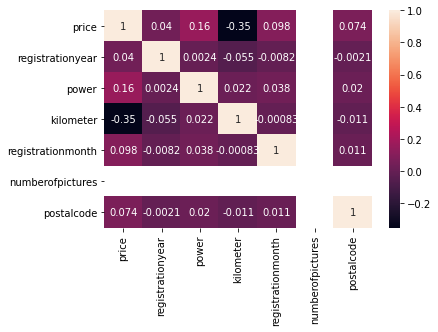

In [476]:
seaborn.heatmap(df.corr(), annot=True)

Сильной корреляции между признаками нет

<AxesSubplot:>

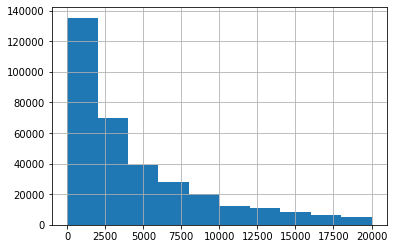

In [477]:
df.price.hist()

<AxesSubplot:>

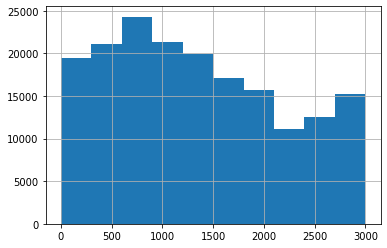

In [478]:
df.price.hist(range=(0,3000))

Посмотрим характеристики "бесплатных" машин

In [479]:
display(df[df['price']>2000].head())
display(len(df[df['price']>2000]))

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
11,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17


196174

Посмотрим на примере одной марки и модели. Изменяется ли цена

<AxesSubplot:>

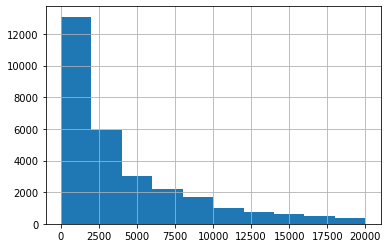

In [480]:
vw_golf = df[df['brand']=='volkswagen'] 
vw_golf = vw_golf[vw_golf['model']=='golf'] 
vw_golf['price'].hist()

In [481]:
vw_golf_2016 = vw_golf[vw_golf['registrationyear']==2016]
vw_golf_2016

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
35,2016-03-08 07:54:46,350,sedan,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
541,2016-03-18 22:48:44,4550,sedan,2016,manual,101,golf,150000,8,gasoline,volkswagen,no,2016-03-18 00:00:00,0,52062,2016-03-25 03:47:16
598,2016-04-05 00:58:16,12000,sedan,2016,manual,105,golf,70000,6,petrol,volkswagen,no,2016-04-04 00:00:00,0,64823,2016-04-07 11:15:35
1026,2016-03-20 11:50:22,9200,sedan,2016,manual,75,golf,40000,8,petrol,volkswagen,no,2016-03-20 00:00:00,0,56727,2016-04-06 10:16:21
1179,2016-03-08 10:38:32,600,sedan,2016,manual,60,golf,150000,11,petrol,volkswagen,yes,2016-03-08 00:00:00,0,41749,2016-03-10 01:16:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352518,2016-03-19 17:54:12,0,sedan,2016,manual,90,golf,150000,7,petrol,volkswagen,yes,2016-03-19 00:00:00,0,57334,2016-04-07 04:45:13
353015,2016-03-26 12:37:56,30,sedan,2016,manual,75,golf,150000,10,petrol,volkswagen,yes,2016-03-26 00:00:00,0,84048,2016-04-05 23:46:46
353175,2016-03-16 16:55:57,4500,sedan,2016,manual,0,golf,150000,11,petrol,volkswagen,yes,2016-03-16 00:00:00,0,63477,2016-04-02 21:18:45
354068,2016-03-17 22:06:35,3700,sedan,2016,manual,90,golf,150000,4,gasoline,volkswagen,yes,2016-03-17 00:00:00,0,55122,2016-03-19 16:30:51


<AxesSubplot:ylabel='Frequency'>

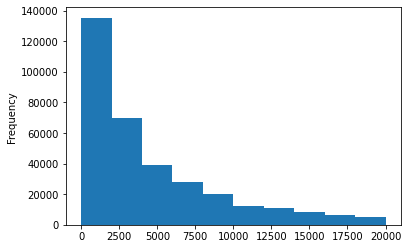

In [482]:
df['price'].plot(kind='hist')

<AxesSubplot:>

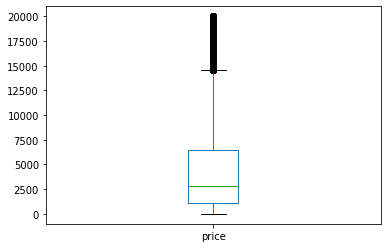

In [483]:
df['price'].plot(kind='box')

Данные за 2016 год для одной машины. Если обратить внимание на 2 последние строки, то машины идентичны. Разница только в мощности. А в цене разницы почти в 10 раз. 

Скорее всего, на цену влияют другие факторы, которые не указаны в наших данных. Это может быть связано с техническим состоянием, может быть машина битая, или что-то в этом роде. Но, нам нужно построить модель, которая будет адекватно предсказывать на текущем наборе данных. Ограничим значения цены более менее адекватными значениями от 2000 до 15000. По хорошему, нужно больше прнизнаков, которые влияют на цену.

In [484]:
df = df[df['price']>2000]

In [485]:
len(df) # количество строк сократилось почти в 2 раза

196174

In [486]:
df

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
11,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354361,2016-03-09 13:37:43,5250,wagon,2016,auto,150,159,150000,12,petrol,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Столбцы datecrawled, datecreated, postalcode и lastseen не будут влиять на обучение. Удалим их

In [487]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'], format='%Y-%m-%d %H:%M:%S')
df['datecreated'] = pd.to_datetime(df['datecreated'], format='%Y-%m-%d %H:%M:%S')
df['datecreated'] = pd.DatetimeIndex(df['datecreated']).year

In [488]:
df['datecreated'].value_counts()

2016    196154
2015        19
2014         1
Name: datecreated, dtype: int64

In [489]:
df.duplicated().sum()

0

In [490]:
df[df['registrationyear']>2016]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
22,2016-03-23 14:52:51,2900,bus,2018,manual,90,meriva,150000,5,petrol,opel,no,2016,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,sedan,2017,manual,125,c4,125000,4,petrol,citroen,no,2016,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,sedan,2017,manual,80,golf,100000,1,petrol,volkswagen,yes,2016,0,48499,2016-03-31 21:47:44
57,2016-03-10 20:53:19,2399,sedan,2018,manual,64,other,125000,3,petrol,seat,no,2016,0,33397,2016-03-25 10:17:37
65,2016-03-28 17:41:27,10900,sedan,2017,manual,101,astra,50000,3,petrol,opel,no,2016,0,63607,2016-04-06 23:15:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353844,2016-03-20 16:37:55,2250,small,2017,manual,60,corsa,150000,8,petrol,opel,no,2016,0,44536,2016-04-04 19:45:04
354099,2016-03-17 15:45:46,4900,small,2017,manual,69,polo,150000,12,gasoline,volkswagen,yes,2016,0,32791,2016-03-25 17:51:29
354112,2016-03-11 15:49:51,3600,bus,2017,manual,86,transit,150000,5,gasoline,ford,yes,2016,0,32339,2016-03-12 05:45:02
354203,2016-03-17 00:56:26,2140,small,2018,manual,80,fiesta,150000,6,petrol,ford,no,2016,0,44866,2016-03-29 15:45:04


In [491]:
df = df.drop(['datecrawled', 'datecreated', 'postalcode','lastseen'], axis=1)

In [492]:
df.numberofpictures.value_counts()

0    196174
Name: numberofpictures, dtype: int64

Столбец numberofpictures состоит из нулей. Удалим

In [493]:
df = df.drop(['numberofpictures'], axis=1)

<AxesSubplot:>

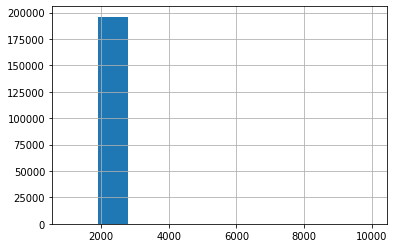

In [494]:
df.registrationyear.hist()

В столбце с годом регистрации тоже есть выбросы, удалим.

In [495]:
df = df[df['registrationyear']>=1980]
df = df[df['registrationyear']<=2022] #тут с 2022 исправил на 2016

<AxesSubplot:>

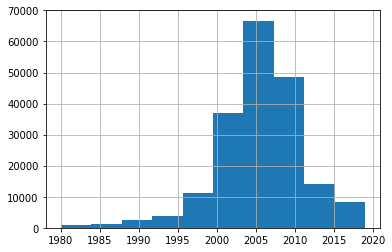

In [496]:
df.registrationyear.hist()

In [497]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth
count,194206.000000,194206.000000,194206.000000,194206.000000,194206.000000
mean,6979.941258,2005.684711,131.733582,121884.957210,6.180880
std,4434.904505,5.552339,180.470503,39775.319248,3.525806
min,2001.000000,1980.000000,0.000000,5000.000000,0.000000
25%,3490.000000,2003.000000,90.000000,100000.000000,3.000000
50%,5550.000000,2006.000000,125.000000,150000.000000,6.000000
75%,9450.000000,2009.000000,163.000000,150000.000000,9.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000


Остался последний столбец - "power". Тут есть выбросы и нулевые значения, избавимся от них.

<AxesSubplot:>

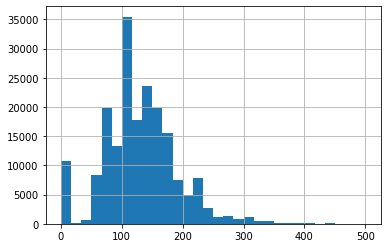

In [498]:
df.power.hist(range=(0,500), bins=30)

In [499]:
df = df[df['power']>30]
df = df[df['power']<=600]

<AxesSubplot:ylabel='Frequency'>

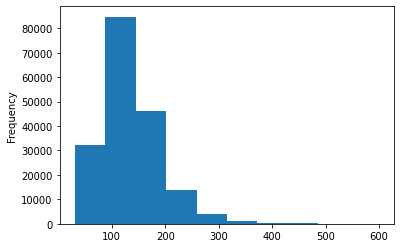

In [500]:
df['power'].plot(kind='hist')

Итоговый набор данных составляет 183 119 строк. Укоротили наш набор в 2 раза

In [501]:
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no
354361,5250,wagon,2016,auto,150,159,150000,12,petrol,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


### Кодирование данных

In [502]:
encoder = OrdinalEncoder()

encoder.fit(df[["vehicletype", "gearbox", "model", "fueltype", "brand", "notrepaired"]])
df[["vehicletype", "gearbox", "model", "fueltype", 
    "brand", "notrepaired"]] = encoder.transform(df[["vehicletype", "gearbox", 
                                                     "model", "fueltype", "brand", "notrepaired"]])


In [503]:
df.duplicated().sum()

15849

Разделим данные на обучающую, тестовую и валидацонную выборки и масштабируем признаки

In [505]:
features = df.drop(['price'], axis=1)
target = df['price'] 

scaler = StandardScaler()
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=148)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=148)

features_train = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)

features_valid = pd.DataFrame(scaler.transform(features_valid), columns=features_valid.columns)

features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)



Данные готовы к дальнейшей работе

## Обучение моделей

### Линейная регрессия

In [95]:
%%time
model = LinearRegression()
scores_LinearRegression = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=3)
print(scores_LinearRegression)
print((scores_LinearRegression.mean()*(-1))**0.5)

[-9034569.28095778 -8936974.65437275 -8855990.28614233]
2990.403218155976
CPU times: user 259 ms, sys: 317 ms, total: 576 ms
Wall time: 539 ms


### Дерево решений

In [96]:
%%time
grid = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : range(1,11), 
    'random_state' : [148],
}
rf_cv = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=grid, cv= 5, scoring='neg_mean_squared_error')
rf_cv.fit(features_train, target_train)

CPU times: user 6.7 s, sys: 34.1 ms, total: 6.73 s
Wall time: 6.75 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 11),
                         'max_features': ['sqrt', 'log2'],
                         'random_state': [148]},
             scoring='neg_mean_squared_error')

In [97]:
rf_cv.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'random_state': 148}

In [98]:
model = DecisionTreeRegressor(max_depth=10, max_features='sqrt', random_state=148)
scores = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error')
print(scores)
print((scores.mean()*(-1))**0.5)

[-5511980.27793031 -5468960.88994229 -5563595.38571428 -5718619.53511911
 -5352190.3649719 ]
2350.121122567001


In [99]:
%%time
model = DecisionTreeRegressor(max_depth=10, max_features='sqrt', random_state=148)
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
score_DecisionTreeRegressor = mean_squared_error(target_valid, prediction)
print('RMSE:', score_DecisionTreeRegressor**0.5)

RMSE: 2323.1943475016146
CPU times: user 128 ms, sys: 47 µs, total: 128 ms
Wall time: 126 ms


### Случайный лес


In [100]:
grid = { 
    'n_estimators': range(1,50, 10),
    'max_features': ['sqrt', 'log2'],
    'max_depth' : range(1,11),
    'random_state' : [148]
}

In [101]:
%%time
rf_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5, scoring='neg_mean_squared_error')
rf_cv.fit(features_train, target_train)

CPU times: user 5min, sys: 656 ms, total: 5min 1s
Wall time: 5min 2s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 11),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': range(1, 50, 10),
                         'random_state': [148]},
             scoring='neg_mean_squared_error')

In [102]:
rf_cv.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 41,
 'random_state': 148}

In [103]:
model = RandomForestRegressor(max_depth= 10, n_estimators=41, max_features='sqrt' , random_state=148)
scores = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error')
print(scores)
print((scores.mean()*(-1))**0.5)

[-4105842.39163496 -4146147.32013344 -4150673.10827433 -4117397.32722709
 -3961845.1885809 ]
2023.9518440837821


In [104]:
%%time
model = RandomForestRegressor(max_depth= 10, n_estimators=41, max_features='sqrt' , random_state=148)
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
score_RandomForestRegressor = mean_squared_error(target_valid, prediction)
print('RMSE:', score_RandomForestRegressor**0.5)

RMSE: 2028.742590228559
CPU times: user 2.74 s, sys: 3.91 ms, total: 2.74 s
Wall time: 2.74 s


### CatBoost

In [105]:
grid = { 
    'learning_rate': [0.03, 0.1],
    'iterations': [100],
    'depth' : range(4,11),
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [106]:
%%time
rf_cv = GridSearchCV(estimator=CatBoostRegressor(loss_function="RMSE", verbose=False), param_grid=grid, cv= 5)
rf_cv.fit(features_train, target_train)

CPU times: user 10min, sys: 6.43 s, total: 10min 6s
Wall time: 11min 32s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe9ca269880>,
             param_grid={'depth': range(4, 11), 'iterations': [100],
                         'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.03, 0.1]})

In [107]:
rf_cv.best_params_

{'depth': 10, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [108]:
%%time
model_Cat = CatBoostRegressor(loss_function="RMSE", iterations=100, depth= 10, l2_leaf_reg=1, learning_rate=0.1, verbose=False)
model_Cat.fit(features_train, target_train, plot=True)
prediction = model_Cat.predict(features_valid)
score_CatBoostRegressor = mean_squared_error(target_valid, prediction)
print('RMSE:', score_CatBoostRegressor**0.5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE: 1845.1651150814712
CPU times: user 3.45 s, sys: 28.2 ms, total: 3.48 s
Wall time: 3.73 s


### LightGBM


In [408]:
grid = { 
    'max_depth': range(3,8,2),
    'num_leaves':range(50, 170, 30)
} 

In [409]:
%%time
rf_cv = GridSearchCV(estimator=LGBMRegressor(), param_grid=grid, cv= 3, scoring='neg_mean_squared_error')
rf_cv.fit(features_train, target_train)

KeyboardInterrupt: 

In [506]:
%%time
model_LGBM = LGBMRegressor(num_leaves=110, max_depth= 7, metric='rmse')
model_LGBM.fit(features_train, target_train)
prediction = model_LGBM.predict(features_valid)
score_LGBMRegressor = mean_squared_error(target_valid, prediction)
print('RMSE:', score_LGBMRegressor**0.5)

KeyboardInterrupt: 

## Анализ моделей

Сравним модели и полученные результаты.

In [ ]:
final_stats = pd.DataFrame(data=[['Линейная регрессия', '361 ms', '361 ms', (scores_LinearRegression.mean()*(-1))**0.5], 
                               ['Дерево решений', '5.41 s', '98 ms', score_DecisionTreeRegressor**0.5], 
                               ['Случайный лес', '5min 3s', '2.32 s', score_RandomForestRegressor**0.5],
                                 ['CatBoost', '12min 18s', '3.7 s', score_CatBoostRegressor**0.5],
                                 ['LightGBM', '6min 41s', '4.07 s', score_LGBMRegressor**0.5]],
                         columns=[['Модель', 'Время обучения', 
                                   'Время предсказания', 'RMSE']])
final_stats

Минимальную ошибку показала модель LightGBM. Время обучения 1min 56s, время предсказания 4.19 s. Обучение довольно быстрым и точным всего с двумя гиперпараметрами

Обучим лучшую модель на более большом наборе данных (train+valid) и протестируем на тестовой выборке.

In [ ]:
features = features_train.append(features_valid, ignore_index=True)
target = target_train.append(target_valid, ignore_index=True)

In [507]:
%%time
model_LGBM = LGBMRegressor(num_leaves=110, max_depth= 7, metric='rmse')
model_LGBM.fit(features, target)
prediction_LGBM = model+_LGBM.predict(features_test)
score_LGBMRegressor = mean_squared_error(target_test, prediction_LGBM)
print('RMSE:', score_LGBMRegressor**0.5)

KeyboardInterrupt: 

Вышесказанное подтвердилось - лучшая модель LightGBM, которая лучашая по всем параметрам оценки: время обучения, время предсказания и RMSE=1828.457 на валидационной и RMSE=1817.688 на тестовой выборках соответственно